In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time_series.time_series_models import KernelRidgeRegression
from time_series.kernels import GaussianKernel

2025-11-13 11:49:47.348 | INFO     | time_series.config:<module>:13 - PROJ_ROOT path is: /home/james/Repo/PhD Repo/time_series_clustering


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score
from sklearn.cluster import KMeans

In [3]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

In [4]:
import itertools
import tqdm

In [5]:
class DataHolder:
    def __init__(self, **kwargs):
        self.update(**kwargs)
    
    def update(self, **kwargs):
        self.__dict__.update(kwargs)

In [6]:
class GridSearch:
    def __init__(self, estimator, param_grid, scoring=None, nfolds=5):
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring if scoring else mean_squared_error
        self.nfolds = nfolds
    
    def fit(self, X, y=None):
        param_names = list(self.param_grid.keys())
        param_values = list(itertools.product(*self.param_grid.values()))

        result = []

        best_score = np.inf
        best_params = []
        
        for p in param_values:
            mapping = {param_names[i]:p[i] for i in range(len(param_names))}
            model = self.estimator(**mapping)

            kf = KFold(n_splits=self.nfolds, random_state=None, shuffle=False)
            scores = []
            
            for i, (train_index, test_index) in enumerate(kf.split(X)):
                X_train = X[train_index]
                X_test = X[test_index]

                y_train = y[train_index]
                y_test = y[test_index] 

                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)

                score = self.scoring(y_test, y_pred)
                scores.append(score)
            
            cv_score = np.mean(scores)
            result.append(
                (mapping, cv_score)
            )

            if cv_score < best_score:
                best_score = cv_score
                best_params = p
        
        self.best_score = best_score
        self.best_params = best_params

        self.cv_results = result


In [7]:
class KRRWrapper(BaseEstimator):
    def __init__(self, bandwidth, reg):
        self.model = KernelRidgeRegression(
            kernels=[GaussianKernel(bandwidth=bandwidth)],
            reg = reg
        )

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

In [8]:
def generate_time_series(x0, f, N=200):
    x = np.zeros(shape=(N))
    x[0] = x0
    for i in range(1, N):
        x[i] = f(x[i-1])
    return x

In [ ]:
epsilon = 1e-2
n_sets = 10

f1 = lambda x: np.exp(-(x-1)**2) + np.random.normal(0, epsilon)
f2 = lambda x: np.exp(-(x+1)**2) + np.random.normal(0, epsilon)
f3 = lambda x: np.exp(-(x)**2) + np.random.normal(0, epsilon)

dynamics = [f1, f2, f3]

datasets = []

for d_id, fd in enumerate(dynamics):
    for i in range(n_sets):
        x0 = np.random.random()
        d = generate_time_series(x0, fd, 400)
        datasets.append(
            DataHolder(
                data=d,#(d - d.min())/(d.max()- d.min()),
                label=d_id
            )
        )

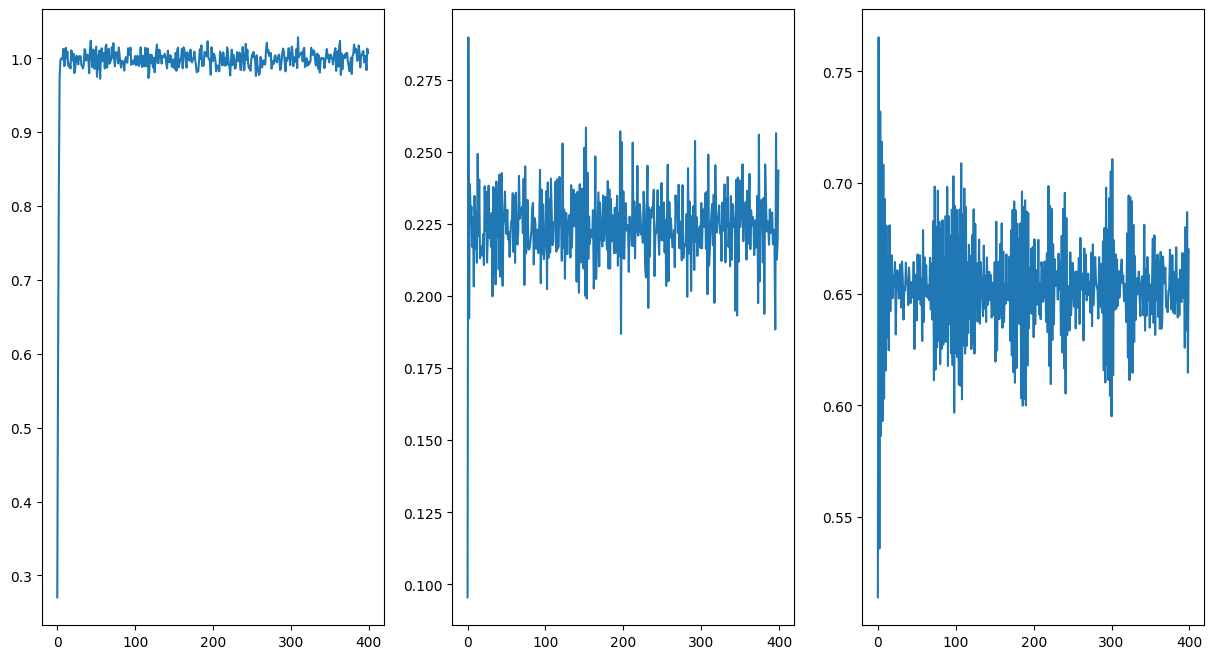

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 8))

ax[0].plot(datasets[0].data)
ax[1].plot(datasets[10].data)
ax[2].plot(datasets[20].data)

In [ ]:
gridsearch = GridSearch(
    KRRWrapper,
    param_grid={
        "bandwidth": np.linspace(0.5, 2, 10),
        "reg": 1/10**np.linspace(1, 12, 20)
    },
    scoring=mean_squared_error
)

In [ ]:
for d in tqdm.tqdm(datasets):
    gridsearch.fit(d.data[:-1], d.data[1:])
    bandwidth, reg = gridsearch.best_params

    model = KernelRidgeRegression(
        kernels=[GaussianKernel(bandwidth=bandwidth)],
        reg = reg
    )

    model.fit(d.data)
    
    d.update(
        bandwidth=bandwidth,
        model=model,
        kernel=model.kernels[0],
        alpha=model.alpha
    )

In [ ]:
# Clustering
similarity_matrix = np.zeros((len(datasets), len(datasets)))
distance_matrix = np.zeros((len(datasets), len(datasets)))

kernel = GaussianKernel(bandwidth=1)

for i in range(len(datasets)):
    dii = (datasets[i].alpha.T@kernel(datasets[i].data[:-1]/datasets[i].bandwidth, datasets[i].data[:-1]/datasets[i].bandwidth)@datasets[i].alpha)[0][0]
    for j in range(i, len(datasets)):
        djj = (datasets[j].alpha.T@kernel(datasets[j].data[:-1]/datasets[j].bandwidth, datasets[j].data[:-1]/datasets[j].bandwidth)@datasets[j].alpha)[0][0]

        dij = (datasets[i].alpha.T@kernel(datasets[i].data[:-1]/datasets[i].bandwidth, datasets[j].data[:-1]/datasets[j].bandwidth)@datasets[j].alpha)[0][0]

        similarity_matrix[i][j] = dij
        distance_matrix[i][j] = dii + djj - 2*dij
        # similarity_matrix[i][j] = dij/np.sqrt(dii*djj) # Cosine distance
        similarity_matrix[j][i] = similarity_matrix[i][j]
        distance_matrix[j][i] = distance_matrix[i][j]


# distance_matrix[distance_matrix < 0] = 0

# # Assuming D is your full distance matrix
# condensed_D = squareform(distance_matrix)  # if D is a full matrix
# Z = linkage(condensed_D, method='average')
# labels = fcluster(Z, t=len(dynamics), criterion='maxclust')  # t is number of clusters

# adjusted_rand_score(
#     labels_true=[d.label for d in datasets],
#     labels_pred=labels
# ), rand_score(
#     labels_true=[d.label for d in datasets],
#     labels_pred=labels  
# )

In [ ]:
# Graph laplacian
D = np.diag(similarity_matrix.sum(axis=0))

L = D - similarity_matrix

evals, evecs = np.linalg.eig(L)
eval_idx = np.argsort(evals)

evals = evals[eval_idx]
evecs = evecs[:, eval_idx]

plt.scatter(evecs[  :10, 0], evecs[  :10, 2])
plt.scatter(evecs[10:20, 0], evecs[10:20, 2])
plt.scatter(evecs[20:30, 0], evecs[20:30, 2])

kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(evecs[:, :4])

cluster_labels = pd.Series(labels)

for c in cluster_labels.unique():
    cluster_indices = cluster_labels[cluster_labels == c].index
    cluster_truth_labels = [datasets[i].label for i in cluster_indices]

    print(f"{c}: {cluster_truth_labels}")

print(adjusted_rand_score(
    labels_true=[d.label for d in datasets],
    labels_pred=labels
), rand_score(
    labels_true=[d.label for d in datasets],
    labels_pred=labels  
))

In [ ]:
plt.imshow(similarity_matrix)

In [ ]:
# distance_matrix[distance_matrix < 0] = 0

# Assuming D is your full distance matrix
condensed_D = squareform(distance_matrix)  # if D is a full matrix
Z = linkage(condensed_D, method='average')
labels = fcluster(Z, t=len(dynamics), criterion='maxclust')  # t is number of clusters

cluster_labels = pd.Series(labels)

for c in cluster_labels.unique():
    cluster_indices = cluster_labels[cluster_labels == c].index
    cluster_truth_labels = [datasets[i].label for i in cluster_indices]

    print(f"{c}: {cluster_truth_labels}")

adjusted_rand_score(
    labels_true=[d.label for d in datasets],
    labels_pred=labels
), rand_score(
    labels_true=[d.label for d in datasets],
    labels_pred=labels  
)

In [ ]:
x = np.linspace(0, 2, 100)
y1 = datasets[0].model.predict(x)
y2 = datasets[10].model.predict(x)
y3 = datasets[20].model.predict(x)

plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)

In [ ]:
plt.plot(x, f1(x), color="red")

for i in range(10):
    plt.plot(x, datasets[i].model.predict(x)
)

In [ ]:
plt.plot(x, f2(x))

for i in range(10, 20):
    plt.plot(x, datasets[i].model.predict(x)
)

In [ ]:
for i in range(20, 30):
    plt.plot(x, datasets[i].model.predict(x)
)

In [ ]:
plt.plot(datasets[0].data[10:])
plt.plot(datasets[10].data[10:])
plt.plot(datasets[20].data[10:])

In [ ]:
# Graph laplacian
D = np.diag(similarity_matrix.sum(axis=0))


L = D - similarity_matrix

evals, evecs = np.linalg.eig(L)
eval_idx = np.argsort(evals)

evals = evals[eval_idx]
evecs = evecs[:, eval_idx]

plt.scatter(evecs[  :10, 0], evecs[  :10, 2])
plt.scatter(evecs[10:20, 0], evecs[10:20, 2])
plt.scatter(evecs[20:30, 0], evecs[20:30, 2])

In [ ]:
# Graph laplacian

S = similarity_matrix - similarity_matrix.min()

D = np.diag(S.sum(axis=0))

L = D - S

evals, evecs = np.linalg.eig(L)
eval_idx = np.argsort(evals)

evals = evals[eval_idx]
evecs = evecs[:, eval_idx]

plt.scatter(evecs[  :10, 1], evecs[  :10, 2])
plt.scatter(evecs[10:20, 1], evecs[10:20, 2])
plt.scatter(evecs[20:30, 1], evecs[20:30, 2])

# Repeated

In [9]:
epsilon = 1e-2
n_sets = 10

f1 = lambda x: np.exp(-(x-1)**2) + np.random.normal(0, epsilon)
f2 = lambda x: np.exp(-(x+1)**2) + np.random.normal(0, epsilon)
f3 = lambda x: np.exp(-(x)**2) + np.random.normal(0, epsilon)

dynamics = [f1, f2, f3]

In [10]:
gridsearch = GridSearch(
    KRRWrapper,
    param_grid={
        "bandwidth": np.linspace(0.5, 2, 20),
        "reg": 1/10**np.linspace(1, 12, 20)
    },
    scoring=mean_squared_error
)

In [11]:
results = dict(
    rand_score = [],
    adj_rand_score = []
)


In [12]:
# Loop
for i in tqdm.tqdm(range(50)):
    datasets = []

    for d_id, fd in enumerate(dynamics):
        for i in range(n_sets):
            x0 = np.random.random()
            d = generate_time_series(x0, fd, 400)
            datasets.append(
                DataHolder(
                    data=d,#(d - d.min())/(d.max()- d.min()),
                    label=d_id
                )
            )

    for d in datasets:
        gridsearch.fit(d.data[:-1], d.data[1:])
        bandwidth, reg = gridsearch.best_params

        model = KernelRidgeRegression(
            kernels=[GaussianKernel(bandwidth=bandwidth)],
            reg = reg
        )

        model.fit(d.data)
        
        d.update(
            bandwidth=bandwidth,
            model=model,
            kernel=model.kernels[0],
            alpha=model.alpha
        )

    # Clustering
    similarity_matrix = np.zeros((len(datasets), len(datasets)))
    distance_matrix = np.zeros((len(datasets), len(datasets)))

    kernel = GaussianKernel(bandwidth=1)

    for i in range(len(datasets)):
        dii = (datasets[i].alpha.T@kernel(datasets[i].data[:-1]/datasets[i].bandwidth, datasets[i].data[:-1]/datasets[i].bandwidth)@datasets[i].alpha)[0][0]
        for j in range(i, len(datasets)):
            djj = (datasets[j].alpha.T@kernel(datasets[j].data[:-1]/datasets[j].bandwidth, datasets[j].data[:-1]/datasets[j].bandwidth)@datasets[j].alpha)[0][0]

            dij = (datasets[i].alpha.T@kernel(datasets[i].data[:-1]/datasets[i].bandwidth, datasets[j].data[:-1]/datasets[j].bandwidth)@datasets[j].alpha)[0][0]

            similarity_matrix[i][j] = dij
            distance_matrix[i][j] = dii + djj - 2*dij
            # similarity_matrix[i][j] = dij/np.sqrt(dii*djj) # Cosine distance
            similarity_matrix[j][i] = similarity_matrix[i][j]
            distance_matrix[j][i] = distance_matrix[i][j]

    # Graph laplacian
    D = np.diag(similarity_matrix.sum(axis=0))

    L = D - similarity_matrix

    evals, evecs = np.linalg.eig(L)
    eval_idx = np.argsort(evals)

    evals = evals[eval_idx]
    evecs = evecs[:, eval_idx]

    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(evecs[:, :4])

    results["rand_score"].append(rand_score(
        labels_true=[d.label for d in datasets],
        labels_pred=labels  
    ))

    results["adj_rand_score"].append(adjusted_rand_score(
        labels_true=[d.label for d in datasets],
        labels_pred=labels  
    ))

 40%|████      | 20/50 [1:08:30<1:42:46, 205.55s/it]


KeyboardInterrupt: 

In [13]:
np.mean(results["rand_score"])

np.float64(0.40344827586206894)

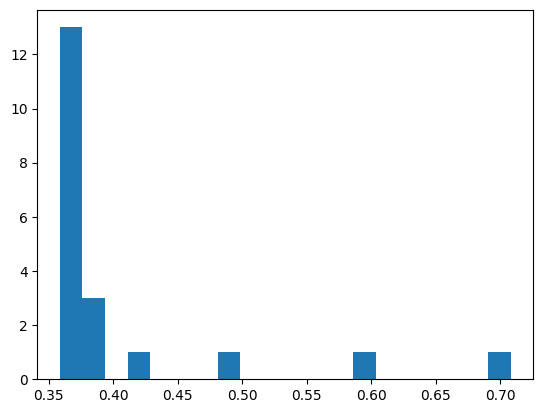

In [14]:
plt.hist(results["rand_score"], bins=20);